# G2G Analysis of Organoid SP T cells vs Type 1 Innate T cells in pan fetal reference

In [2]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import os,sys,inspect
import scanpy as sc

# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils
import VisualUtils

import warnings
warnings.filterwarnings("ignore")
import platform
print(platform.python_version())

(CVXPY) Feb 08 06:33:09 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 08 06:33:09 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


In [2]:
import scipy
scipy.__version__

import leven
leven.__version__

'1.0.4'

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
import gseapy
import sklearn
sklearn.__version__
  #  - scikit-learn==1.3.2
  #  - scipy==1.10.1

'1.2.2'

# Latent dimensional alignment (testing PCA, scVI)

[1.6547761  1.6547761  1.6547761  ... 0.95708966 1.7599797  1.7599797 ]
[2.8278751  1.5119227  2.0882633  ... 0.5269568  0.87026346 0.5269568 ]
(20327, 20240)
(17176, 20240)


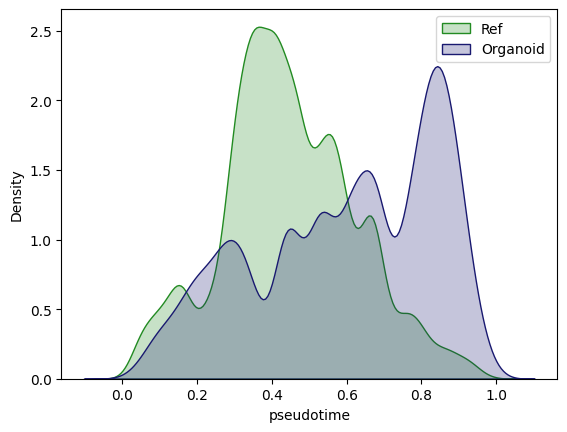

0.0 1.0
0.0 1.0


In [3]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_ref = anndata.read_h5ad(input_dir+'PanfetalATO_SPT_gplvm_ref_24012023.h5ad')
adata_query = anndata.read_h5ad(input_dir +'PanfetalATO_SPT_gplvm_ATO_24012023.h5ad') 
#adata_ref = anndata.read_h5ad('data/adata_ref_spt.h5ad')
#adata_query = anndata.read_h5ad('data/adata_ato_spt.h5ad') 
print(adata_ref.X.data)
print(adata_query.X.data)
print(adata_ref.shape)
print(adata_query.shape)

common_genes = np.intersect1d(adata_ref.var_names, adata_query.var_names)
len(common_genes )
def get_human_TF_list(): 
    # get a human TF list 
    TF_list = pd.read_csv('huamn_TF_list.csv',skiprows=1)
    np.unique(TF_list['Unnamed: 3'], return_counts=True) # There are only 1639 true TFs out of 2765 TFs in this list 
    TF_list = TF_list[TF_list['Unnamed: 3']=='Yes']
    TF_list['Name']
    return TF_list
human_TFs = get_human_TF_list()
human_TFs = np.intersect1d(common_genes , np.asarray(human_TFs['Name']) )
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Ref', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Organoid', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

print(min(adata_ref.obs['time']), max(adata_ref.obs['time'])) 
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

In [4]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

14

In [5]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

15

In [6]:
adata_ref_original = adata_ref.copy()
adata_query_original = adata_query.copy()

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


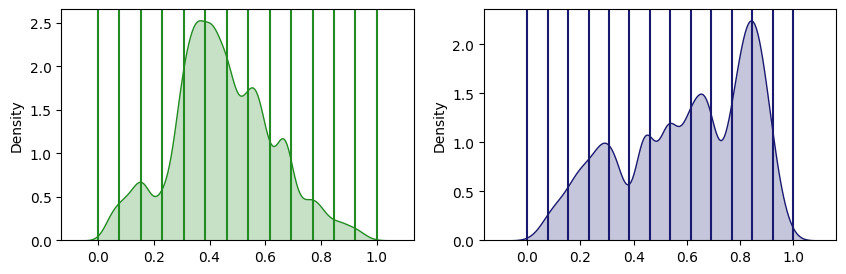

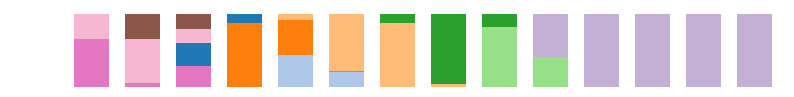

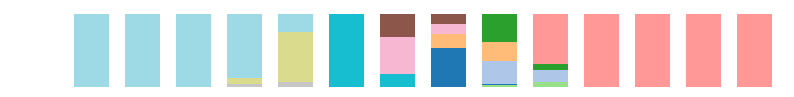

In [7]:
joint_cmap = {'IPSC': '#c7c7c7',
'PRIMITIVE_STREAK': '#9edae5',
'MESODERMAL_PROGENITOR': '#dbdb8d',
'ENDOTHELIUM': '#17becf',
'HSC_MPP': '#f7b6d2',
'HSC_MPP/LMPP_MLP/DC2': '#8c564b',
'LMPP_MLP': '#8c564b',
'CYCLING_MPP': '#e377c2',
'DN(EARLY)_T': '#1f77b4',
'DN(early)_T': '#1f77b4',
'DN_T': '#aec7e8',
'DN(P)_T': '#aec7e8',
'DN(Q)_T': '#ff7f0e',
'DP(P)_T': '#ffbb78',
'DP(Q)_T': '#2ca02c',
'ABT(ENTRY)': '#98df8a',
'SP_T': '#ff9896',
'TYPE_1_INNATE_T': '#c5b0d5'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)


In [10]:
adata_ref = adata_ref_original.copy()
adata_query = adata_query_original.copy()
#ref_scvi = pd.DataFrame(adata_ref.obsm['X_scVI'])
#query_scvi = pd.DataFrame(adata_query.obsm['X_scVI'])
sc.tl.pca(adata_ref, svd_solver='arpack')
sc.tl.pca(adata_query, svd_solver='arpack')

ref_pca = pd.DataFrame(adata_ref.obsm['X_pca']) # X_scvi
query_pca = pd.DataFrame(adata_query.obsm['X_pca']) # X_scvi

adata_ref = anndata.AnnData(X=ref_pca)
adata_query = anndata.AnnData(X=query_pca)
adata_ref.obs_names = adata_ref_original.obs_names
adata_query.obs_names = adata_query_original.obs_names
adata_ref.obs['time'] = adata_ref_original.obs['time']
adata_query.obs['time'] = adata_query_original.obs['time']
adata_ref.obs['ANNOTATION_COMB'] = adata_ref_original.obs['ANNOTATION_COMB']
adata_query.obs['ANNOTATION_COMB'] = adata_query_original.obs['ANNOTATION_COMB']

In [11]:
adata_query.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49'],
      dtype='object')

In [12]:
    # start_time = time.time()
    #gene_list = human_TFs[0:100]
    aligner = Main.RefQueryAligner(adata_ref, adata_query, adata_query.var_names, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    # end_time = time.time() 

WINDOW_SIZE= 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Average Alignment:  IIIDMMMMMMMMMMMDD


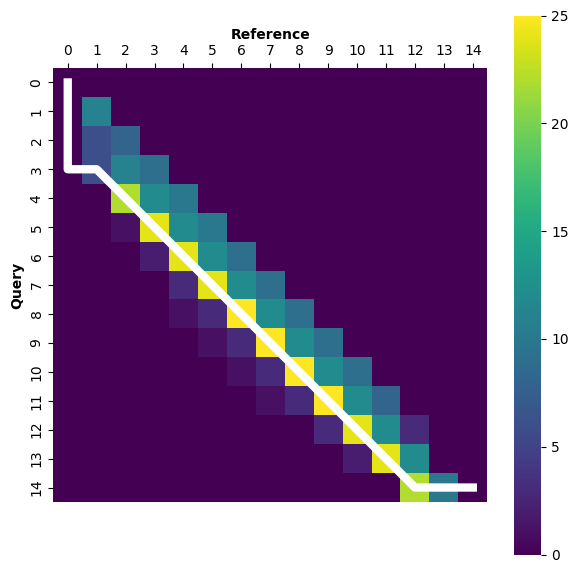

In [14]:
aligner.get_aggregate_alignment() 

In [18]:
#aligner.show_ordered_alignments() 

In [16]:
adata_ref = adata_ref_original.copy()
adata_query = adata_query_original.copy()
ref_scvi = pd.DataFrame(adata_ref.obsm['X_scVI'])
query_scvi = pd.DataFrame(adata_query.obsm['X_scVI'])


adata_ref = anndata.AnnData(X=ref_scvi)
adata_query = anndata.AnnData(X=query_scvi)
adata_ref.obs_names = adata_ref_original.obs_names
adata_query.obs_names = adata_query_original.obs_names
adata_ref.obs['time'] = adata_ref_original.obs['time']
adata_query.obs['time'] = adata_query_original.obs['time']
adata_ref.obs['ANNOTATION_COMB'] = adata_ref_original.obs['ANNOTATION_COMB']
adata_query.obs['ANNOTATION_COMB'] = adata_query_original.obs['ANNOTATION_COMB']
adata_query.var_names


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [17]:
    # start_time = time.time()
    #gene_list = human_TFs[0:100]
    aligner = Main.RefQueryAligner(adata_ref, adata_query, adata_query.var_names, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    # end_time = time.time() 

WINDOW_SIZE= 0.1


  0%|          | 0/10 [00:00<?, ?it/s]

Average Alignment:  IIIDIDIDMMMMMMMMMDD


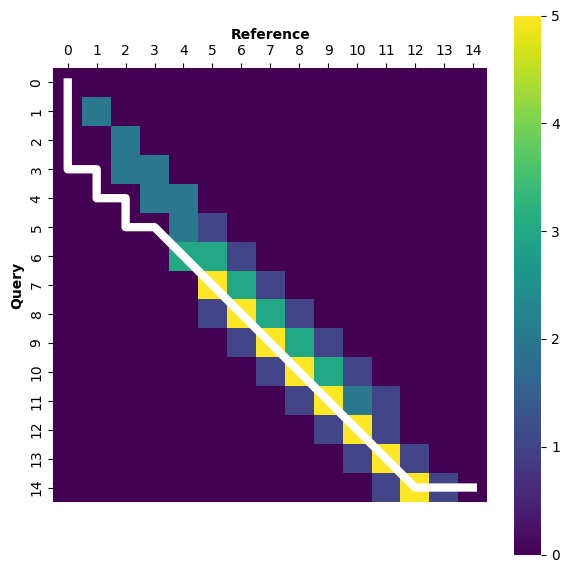

In [22]:
aligner.get_aggregate_alignment() 

In [ ]:
import time

In [ ]:
import multiprocessing
multiprocessing.cpu_count() 

16

In [ ]:
import multiprocessing
multiprocessing.cpu_count() 

16

In [ ]:
    
    start_time = time.time()
    gene_list = human_TFs[0:100]
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    end_time = time.time() 

WINDOW_SIZE= 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
(end_time - start_time)/100

5.573872406482696

In [23]:
len(vs.optimal_bining_S)

14

# Batch subsampling test --- a stability test

In [27]:
adata_ref = adata_ref_original.copy()
adata_query = adata_query_original.copy()

In [8]:
# subsampling batches in the reference for cross validation. 
ref_donors = np.unique(adata_ref.obs.bbk, return_counts=True) 
filter_donors = np.where(ref_donors[1] <50) 
ref_donors = ref_donors[0]
fixed_ref_donors = ref_donors[filter_donors]
ref_donors = ref_donors[[d not in fixed_ref_donors for d in ref_donors] ] 
print(len(ref_donors) + len(fixed_ref_donors))

33


In [9]:
len(ref_donors) 

22

In [10]:
len(fixed_ref_donors)

11

In [11]:
ref_donor_subsets = []

np.random.seed(1234)
for i in range(0,5):
    subset_donors = np.random.choice(ref_donors, 11, replace=False)
    ref_donor_subsets.append(list(subset_donors)) # first from complimentary pair 
    ref_donor_subsets.append(list(np.setdiff1d(ref_donors, subset_donors))) # second from complimentary pair 

In [12]:
len(ref_donor_subsets)

10

In [13]:
adata_ref

AnnData object with n_obs × n_vars = 20327 × 20240
    obs: 'ANNOTATION_COMB', 'time', 'bbk', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
adata_query

AnnData object with n_obs × n_vars = 17176 × 20240
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [15]:
len(human_TFs)

1371

In [16]:
gene_list = human_TFs

In [37]:
len(human_TFs)
joint_cmap = {'IPSC': '#c7c7c7',
'PRIMITIVE_STREAK': '#9edae5',
'MESODERMAL_PROGENITOR': '#dbdb8d',
'ENDOTHELIUM': '#17becf',
'HSC_MPP': '#f7b6d2',
'HSC_MPP/LMPP_MLP/DC2': '#8c564b',
'LMPP_MLP': '#8c564b',
'CYCLING_MPP': '#e377c2',
'DN(EARLY)_T': '#1f77b4',
'DN(early)_T': '#1f77b4',
'DN_T': '#aec7e8',
'DN(P)_T': '#aec7e8',
'DN(Q)_T': '#ff7f0e',
'DP(P)_T': '#ffbb78',
'DP(Q)_T': '#2ca02c',
'ABT(ENTRY)': '#98df8a',
'SP_T': '#ff9896',
'TYPE_1_INNATE_T': '#c5b0d5'}

In [39]:
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase

class InterestingGeneSets:
    
    def __init__(self, MSIGDB_PATH ='../OrgAlign/msigdb/' ):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase(MSIGDB_PATH , version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
        #self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
        #self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
        self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        #print(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]
        
        
IGS = InterestingGeneSets(MSIGDB_PATH='../MSIGDB/msigdb7.5.1/')
IGS.add_new_set_from_msigdb('reac', 'REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPOTENT_STEM_CELLS', aligner.gene_list  , 'Reg_of_Pluripotency')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', common_genes, 'TNF_alpha_signaling_via_NFKB')
IGS.add_new_set(IGS.SETS['TNF_alpha_signaling_via_NFKB']  , 'TNF_alpha_signaling_via_NFKB_TFs', aligner.gene_list)   

0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.026947462300293608 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:01<?, ?it/s]

Average Alignment:  IIIDIDIMMMMMMMMMDDD
1
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDMMMMMMMMMMMDD
2
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDMMMMMMMMMMMDD
3
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIDIMMMMMMMMMDDD
4
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIMMMMMMMMMMDDD
5
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIDMMMMMMMMMIDDD
6
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIDIMMMMMMMMMDDD
7
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIMMMMMMMMMMDDD
8
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIMMMMMMMMMMDDD
9
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/42 [00:00<?, ?it/s]

Average Alignment:  IIIDIDIMMMMMMMMMDDD


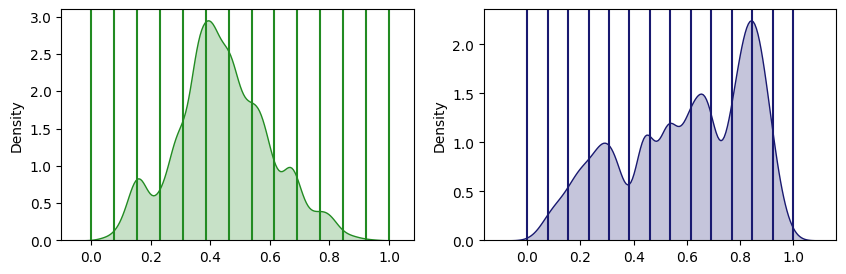

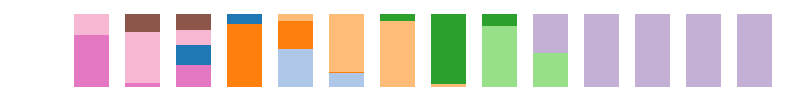

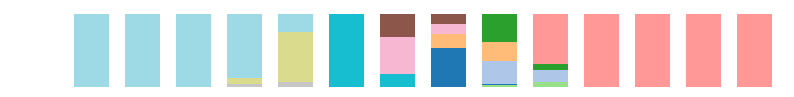

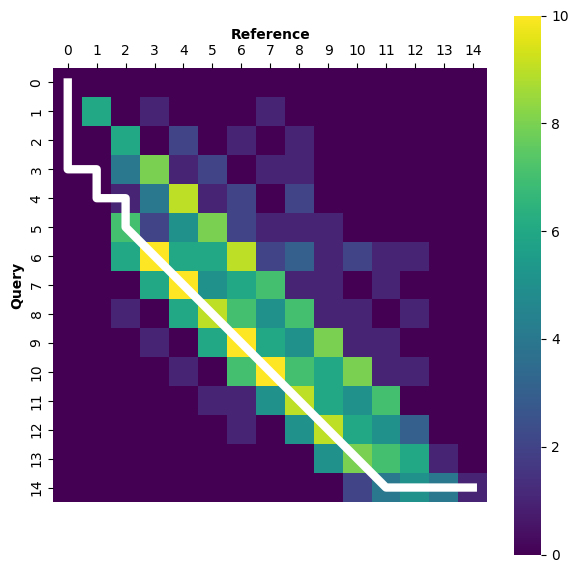

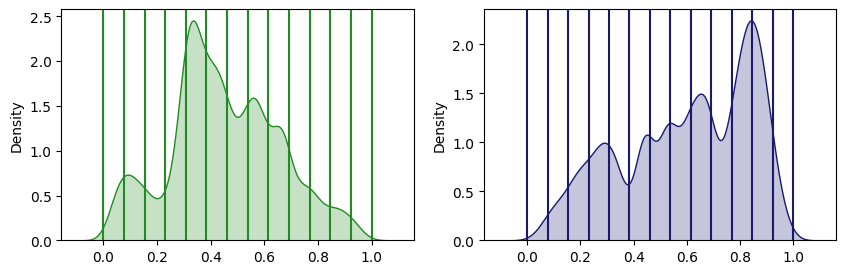

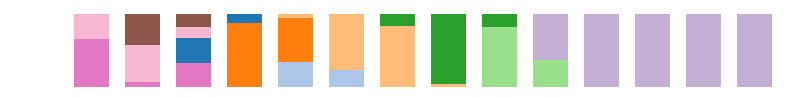

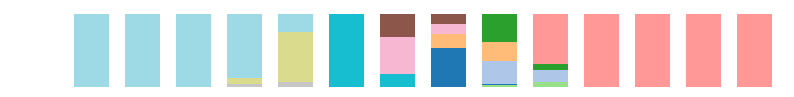

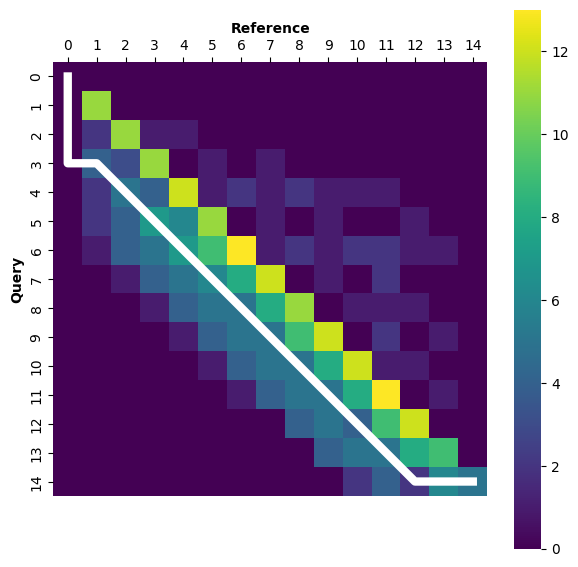

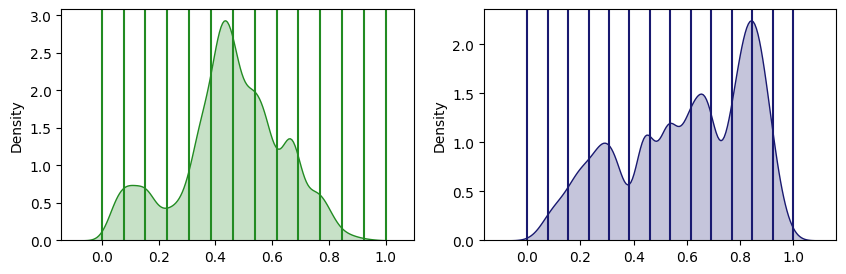

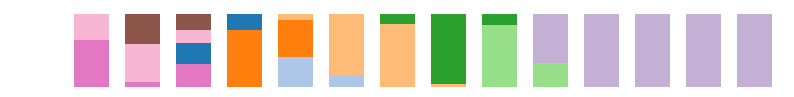

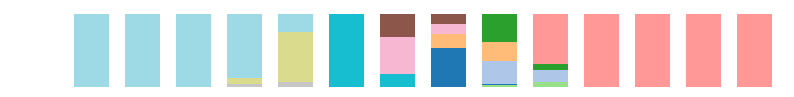

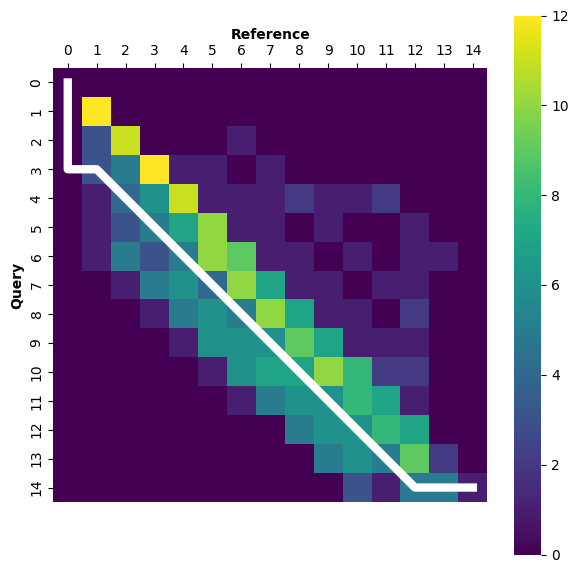

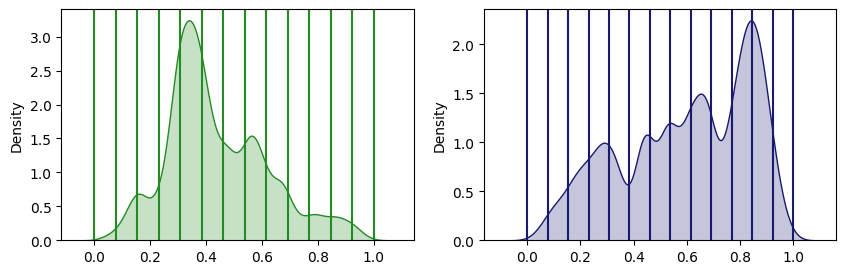

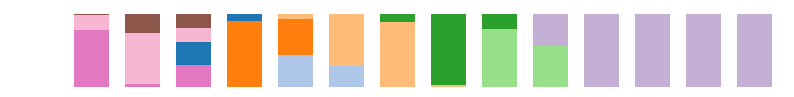

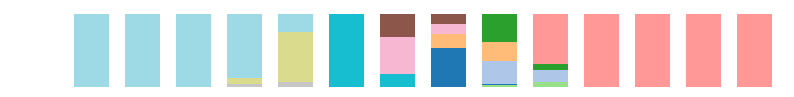

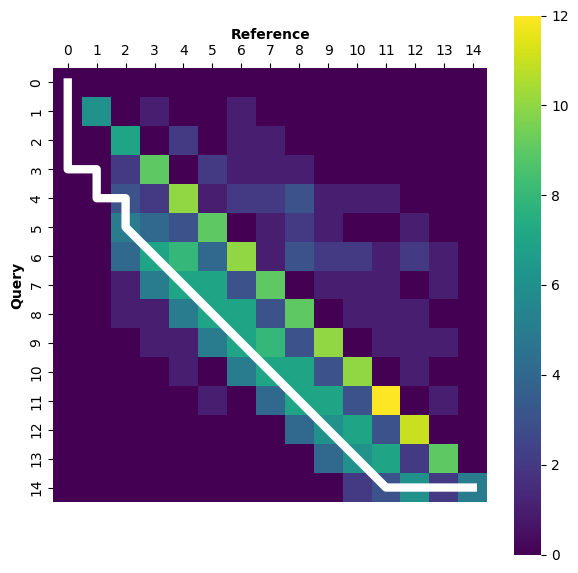

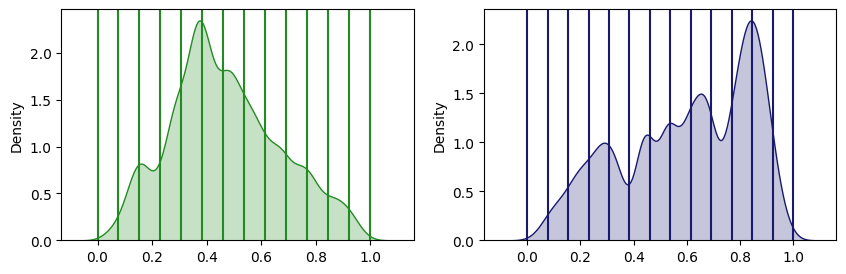

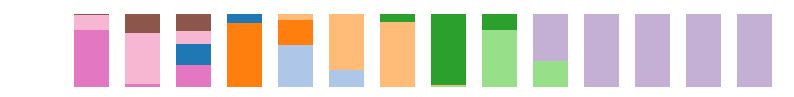

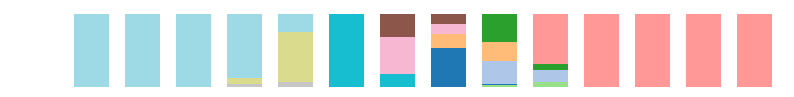

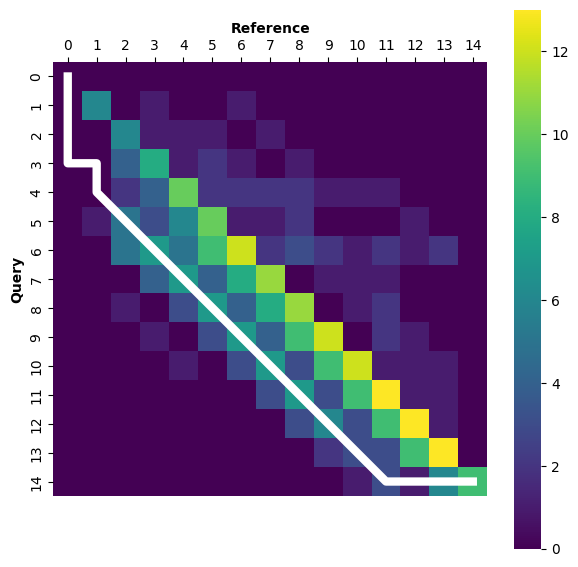

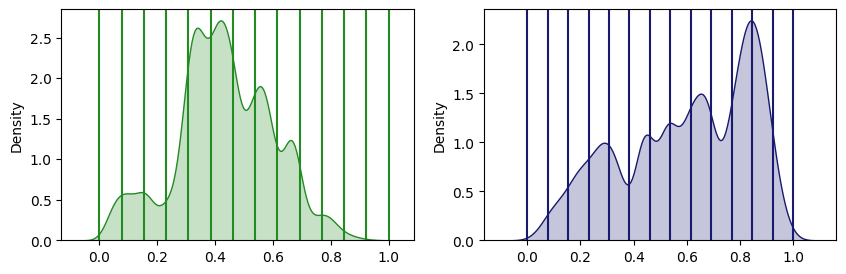

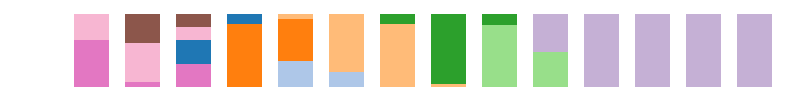

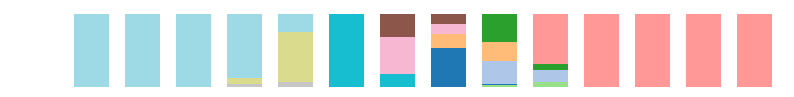

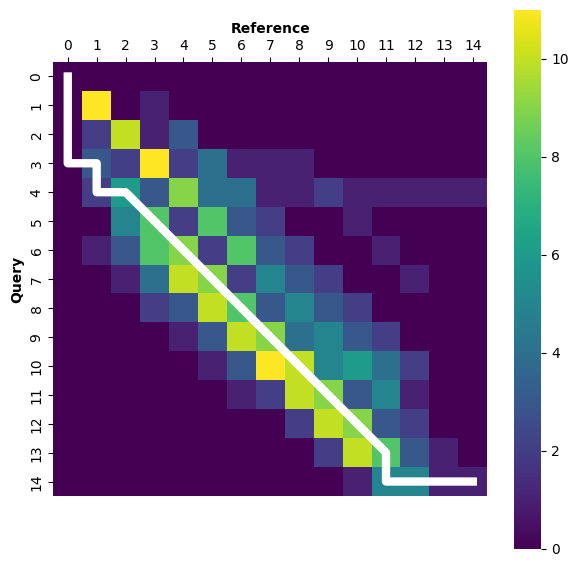

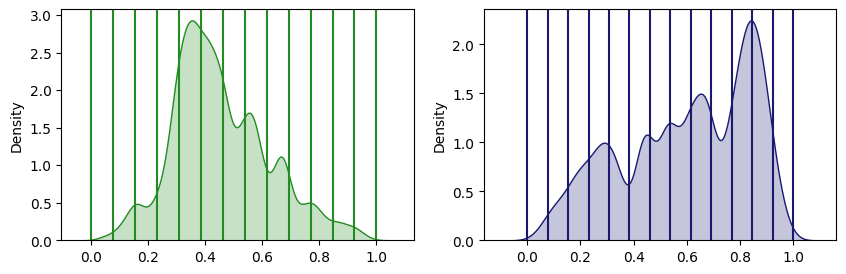

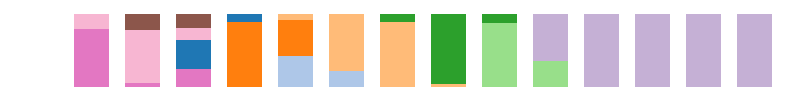

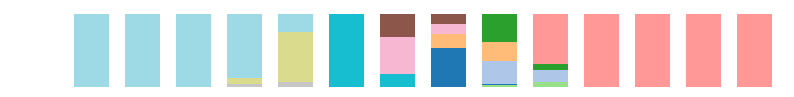

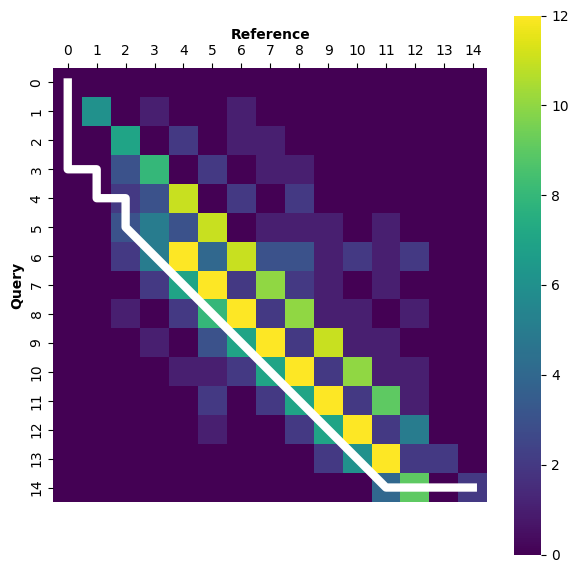

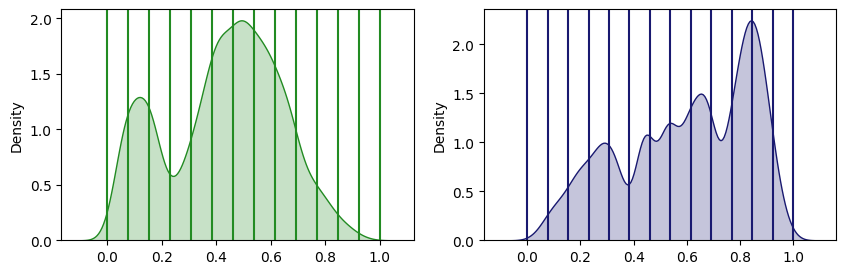

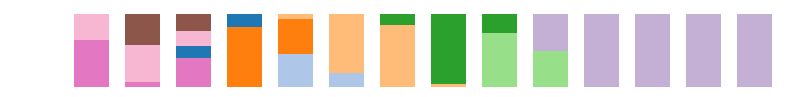

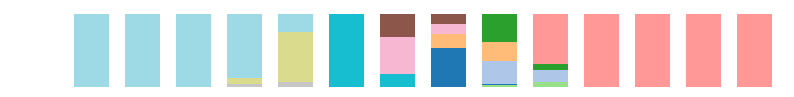

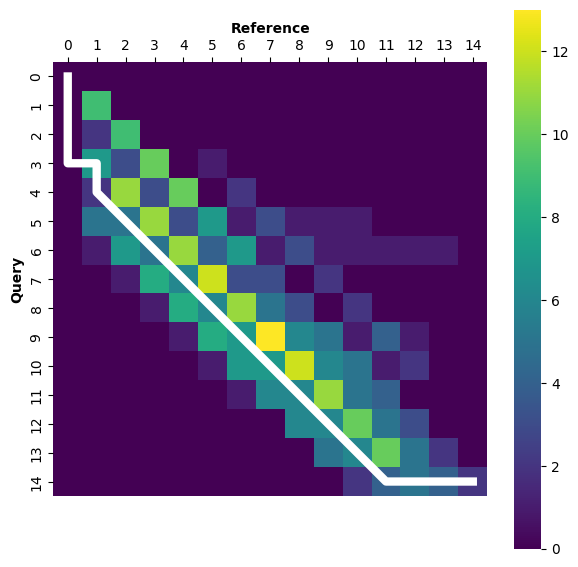

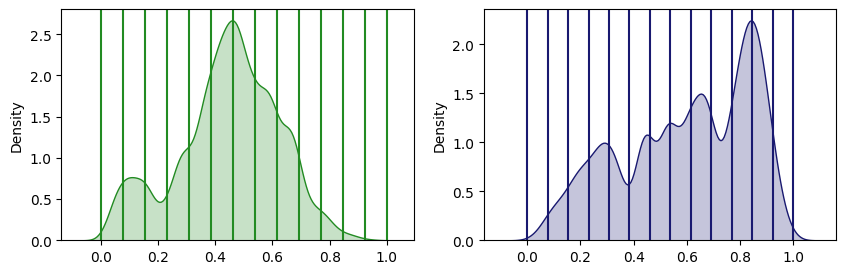

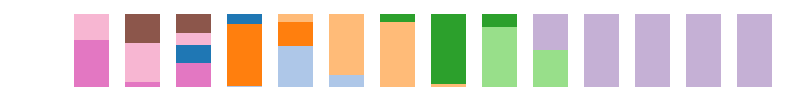

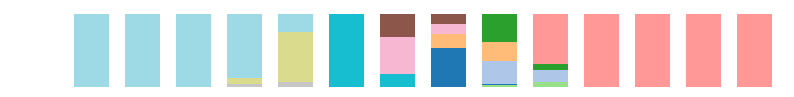

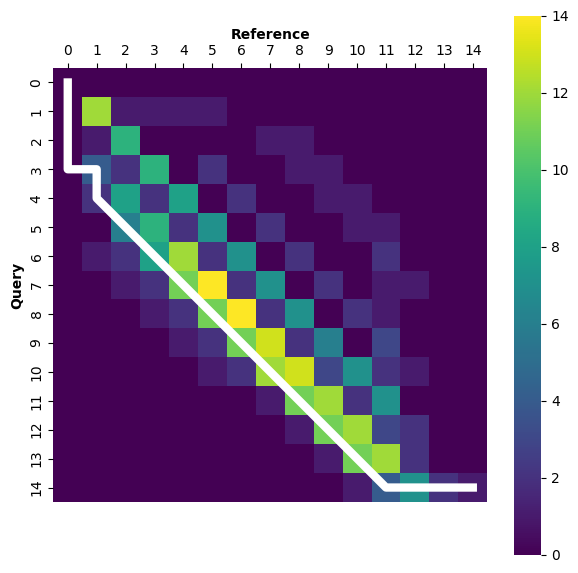

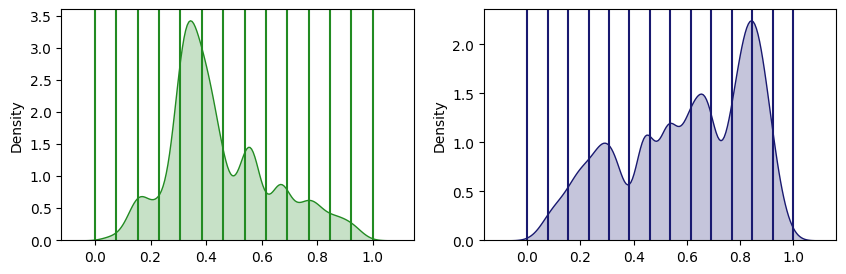

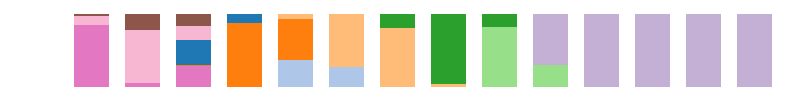

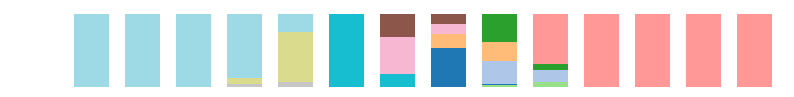

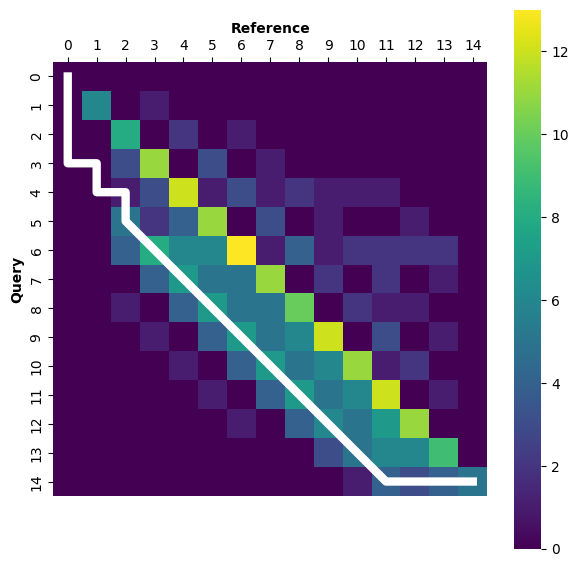

In [40]:

gene_list = IGS.SETS['TNF_alpha_signaling_via_NFKB_TFs']
for i in range(0,10):
    print(i)
    adata_ref = adata_ref_original.copy()
    
    r = ref_donor_subsets[i]
    subset = r+ list(fixed_ref_donors)
 #   print(len(subset), len(np.unique(subset)))

    adata_ref = adata_ref[[donor in subset for donor in adata_ref.obs.bbk]]
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    
    aligner.get_aggregate_alignment()
    

In [ ]:

gene_list = human_TFs
for i in range(2,10):
    print(i)
    adata_ref = adata_ref_original.copy()
    
    r = ref_donor_subsets[i]
    subset = r+ list(fixed_ref_donors)
 #   print(len(subset), len(np.unique(subset)))

    adata_ref = adata_ref[[donor in subset for donor in adata_ref.obs.bbk]]
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    
    aligner.get_aggregate_alignment()
    

2
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIDMMMMMMMMMMMMD
3
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDDMMMMMMMMMMMD
4
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDDMMMMMMMMMMMD
5
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDMMMMMMMMMMMDD
6
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

6
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDDMMMMMMMMMMMD
7
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIDMMMMMMMMMMMMD
8
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDMMMMMMMMMMMDD
9
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDDMMMMMMMMMMMD


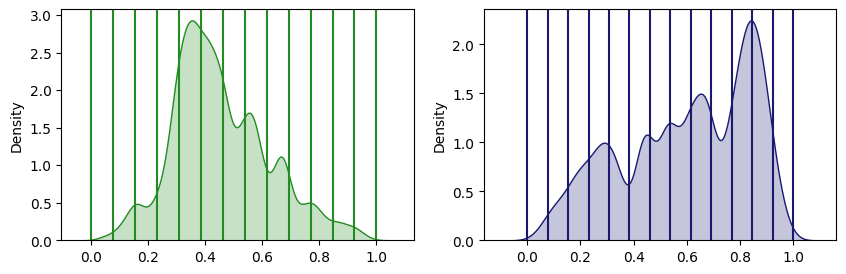

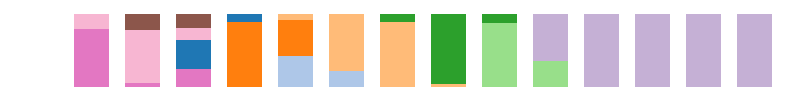

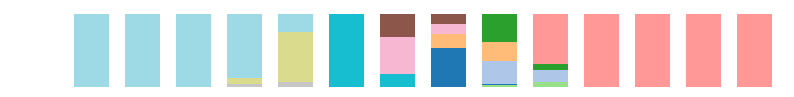

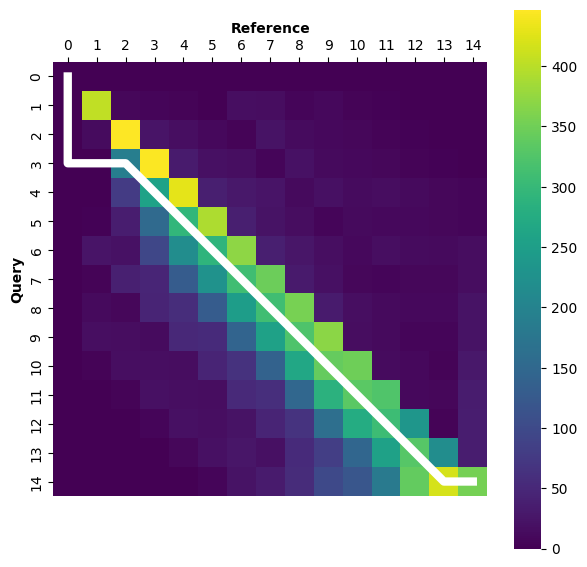

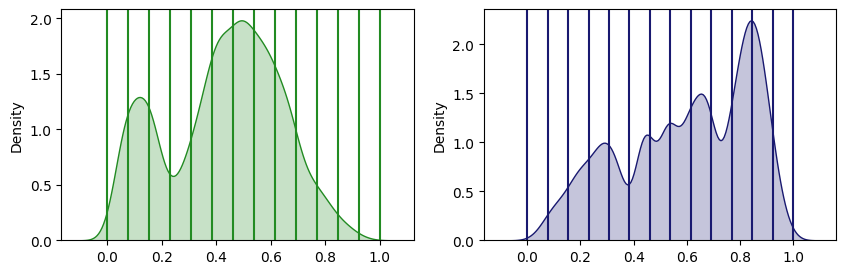

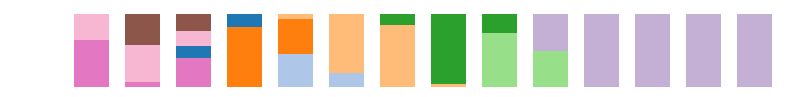

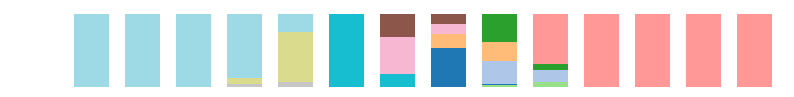

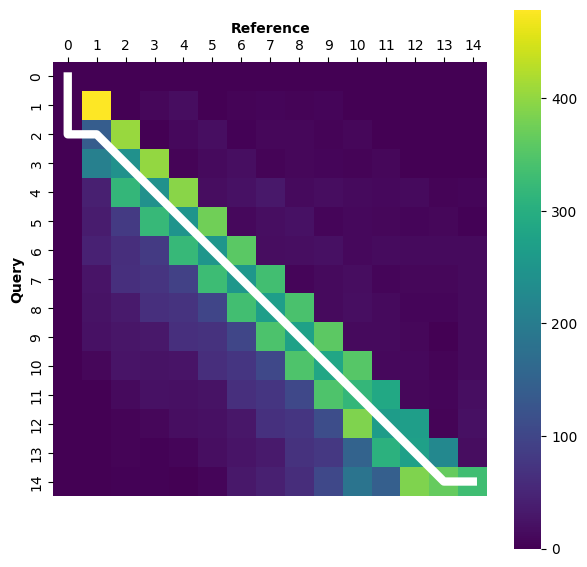

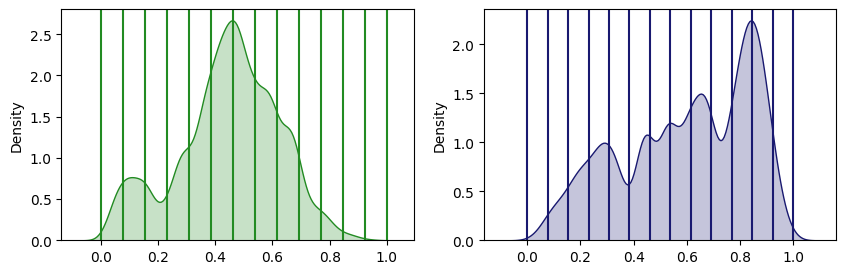

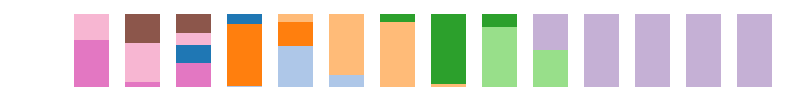

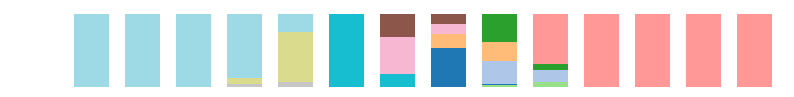

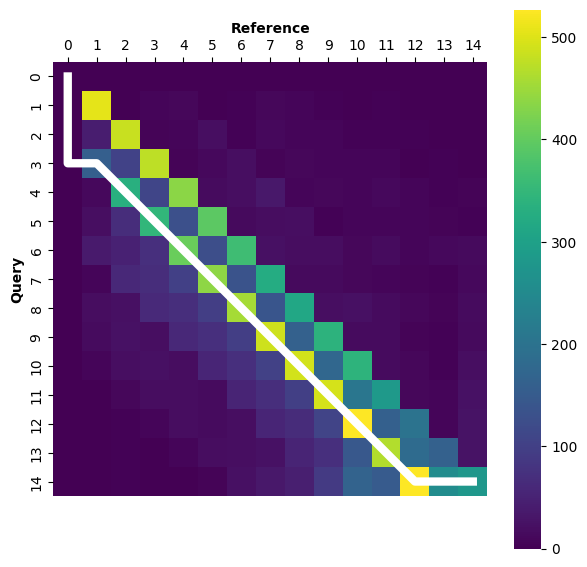

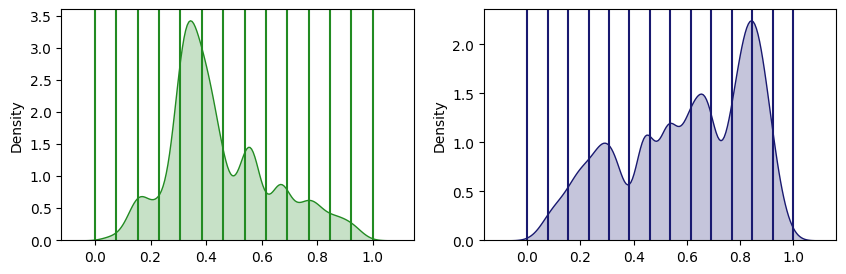

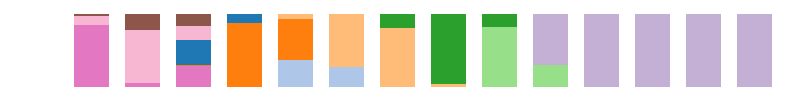

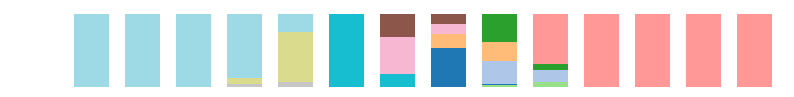

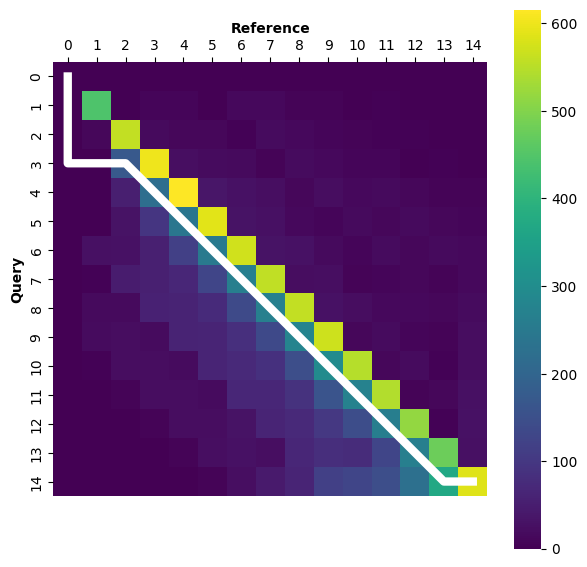

In [20]:

gene_list = human_TFs
for i in range(6,10):
    print(i)
    adata_ref = adata_ref_original.copy()
    
    r = ref_donor_subsets[i]
    subset = r+ list(fixed_ref_donors)
 #   print(len(subset), len(np.unique(subset)))

    adata_ref = adata_ref[[donor in subset for donor in adata_ref.obs.bbk]]
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    
    aligner.get_aggregate_alignment()

In [20]:

gene_list = human_TFs
for i in range(0,10):
    print(i)
    adata_ref = adata_ref_original.copy()
    
    r = ref_donor_subsets[i]
    subset = r+ list(fixed_ref_donors)
 #   print(len(subset), len(np.unique(subset)))

    adata_ref = adata_ref[[donor in subset for donor in adata_ref.obs.bbk]]
    
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
    print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
    print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 
    
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    
    aligner.get_aggregate_alignment()
    

0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.026947462300293608 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIDIDMMMMMMMMMMDD
1
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIDMMMMMMMMMMMMD
2
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
0.0 0.9548093434583151
0.0 1.0
0.0 1.0
0.0 1.0
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Process ForkPoolWorker-48:
Process ForkPoolWorker-41:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-47:
Process ForkPoolWorker-34:
Process ForkPoolWorker-44:
Process ForkPoolWorker-37:
Process ForkPoolWorker-42:
Process ForkPoolWorker-36:
Process ForkPoolWorker-38:
Process ForkPoolWorker-39:
Process ForkPoolWorker-40:
Traceback (most recent call last):
Process ForkPoolWorker-33:
  File "/opt/conda/envs/genes2genes/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/envs/genes2genes/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/genes2genes/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/jupyter/[A]G2G_Latest/Main.py", line 531, in align_single_pair
    self.pairs[gene] = self.run_interpolation(gene)
  File "/home/jupyter/[A]G2G_Lates

Error in callback <function _draw_all_if_interactive at 0x7f79e3eb6ee0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f79e3eb6310> (for post_execute):



KeyboardInterrupt



# Additional test -- Batch to batch alignment within the same system 

In [186]:
# subsampling batches in the reference for cross validation. 
ref_donors = np.unique(adata_ref.obs.bbk, return_counts=True) 
filter_donors = np.where(ref_donors[1] <50) 
ref_donors = ref_donors[0]
fixed_ref_donors = ref_donors[filter_donors]
ref_donors = ref_donors[[d not in fixed_ref_donors for d in ref_donors] ] 
print(len(ref_donors) + len(fixed_ref_donors))

33


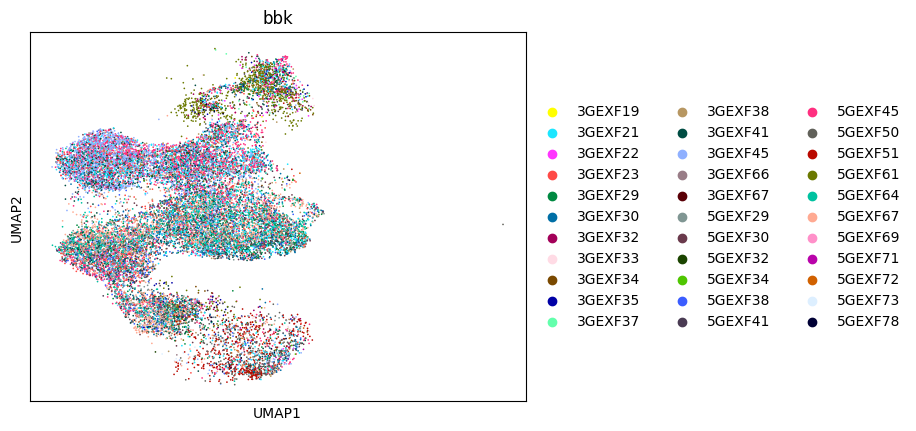

In [187]:
sc.pl.umap(adata_ref, color='bbk')

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


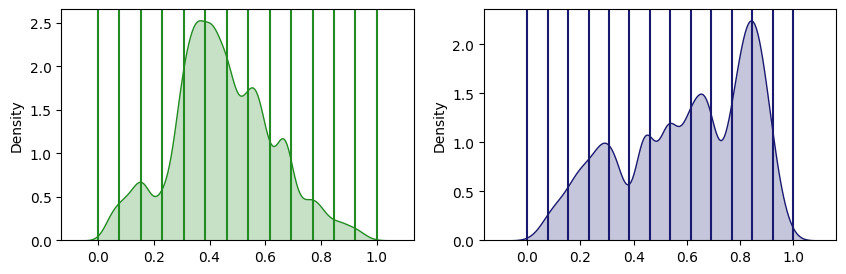

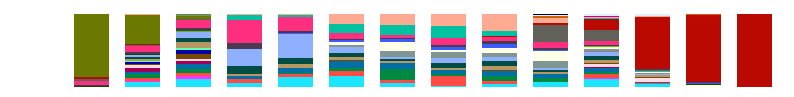

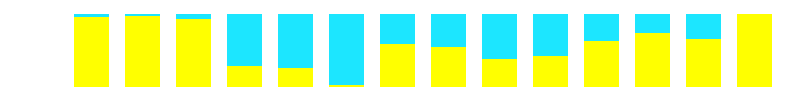

In [99]:
cmap_big = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='bbk', 
                                                              optimal_binning=False,
                                                             ref_cmap=cmap_big , query_cmap=cmap_big , plot_celltype_counts=False)
#vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ref_timebins.pdf')
#vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ato_timebins.pdf')

In [188]:
len(ref_donors)

22

In [189]:
selected_batches

array(['5GEXF51', '5GEXF64'], dtype=object)

In [193]:
adata_ref

AnnData object with n_obs × n_vars = 20327 × 20240
    obs: 'ANNOTATION_COMB', 'time', 'bbk', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p', 'bbk_colors'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Donor2Donor TEST  0 : ['3GEXF32' '3GEXF45']
(107, 20240)
(2456, 20240)
0.11061744271645609 0.8334385974881013
0.11524052348296425 0.8995331307895864
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIMMDVDVVDDVWVVWVWVWVWWWW
Donor2Donor TEST  1 : ['5GEXF29' '3GEXF35']
(695, 20240)
(81, 20240)
0.06563973693373423 0.9154208870079433
0.12487459956494448 0.7981165460971822
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMMMMMVVVDDDMMMMM
Donor2Donor TEST  2 : ['3GEXF38' '3GEXF45']
(790, 20240)
(2456, 20240)
0.1090505199156959 0.9005548120584
0.11524052348296425 0.8995331307895864
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMMM
Donor2Donor TEST  3 : ['3GEXF32' '5GEXF41']
(107, 20240)
(604, 20240)
0.11061744271645609 0.8334385974881013
0.04784761811430353 0.9256360494685224
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIIIMMDDVVDVDVVWWVWVWVWWWW
Donor2Donor TEST  4 : ['3GEXF21' '5GEXF45']
(1709, 20240)
(2329, 20240)
0.09589838082766258 0.9177076581102659
0.02710079858875078 0.8405242303269252
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMMM
Donor2Donor TEST  5 : ['3GEXF22' '5GEXF29']
(56, 20240)
(695, 20240)
0.10036405527332477 0.8082606948252982
0.06563973693373423 0.9154208870079433
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMMMMMWWWIIIMMMMM
Donor2Donor TEST  6 : ['3GEXF34' '5GEXF30']
(89, 20240)
(860, 20240)
0.127648362339957 0.8669134000167545
0.10720651756104332 0.9528657562176112
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  DDMWMMMMWIIIIMMMMM
Donor2Donor TEST  7 : ['3GEXF33' '5GEXF51']
(94, 20240)
(446, 20240)
0.10802948921736157 0.8887497822869858
0.02547386462816807 1.0
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMMM
Donor2Donor TEST  8 : ['5GEXF64' '3GEXF32']
(1592, 20240)
(107, 20240)
0.21276560819140589 0.8157960146734744
0.11061744271645609 0.8334385974881013
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  IIDDMMDDWIIWWWWVVVVVMMM
Donor2Donor TEST  9 : ['5GEXF51' '5GEXF64']
(446, 20240)
(1592, 20240)
0.02547386462816807 1.0
0.21276560819140589 0.8157960146734744
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14
WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

Average Alignment:  MMVVIDIDIIVDDVVVWVWVWWWDDD


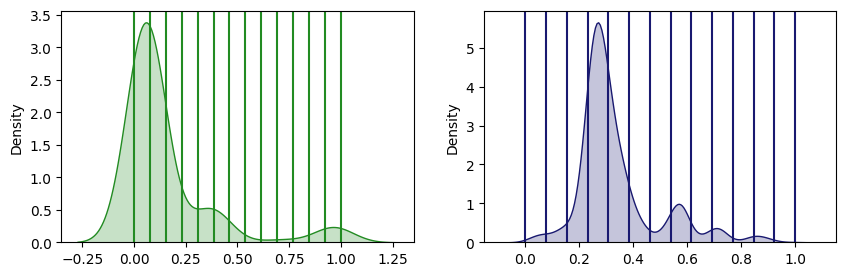

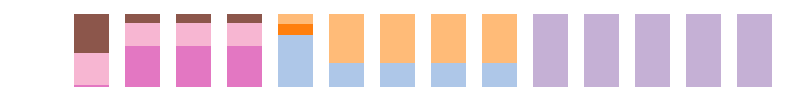

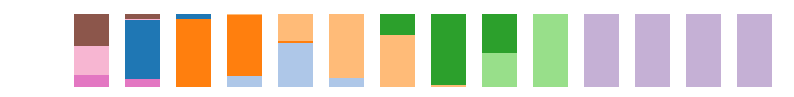

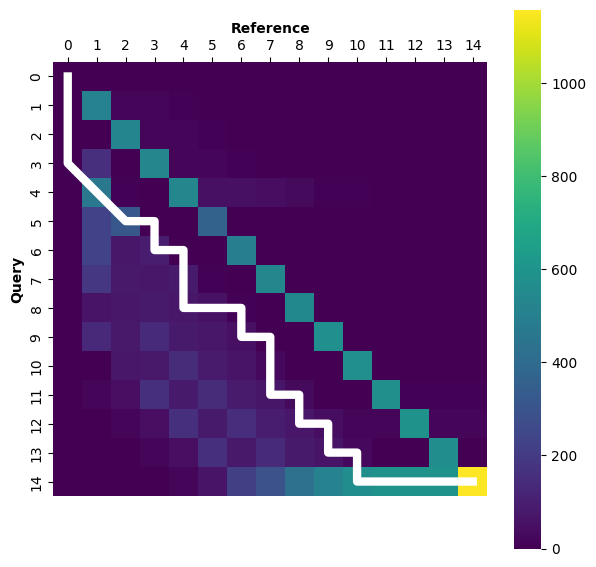

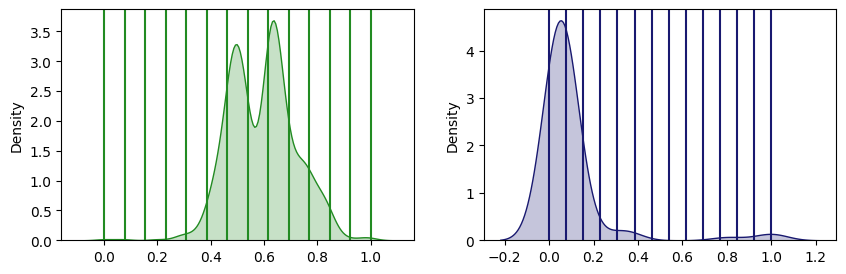

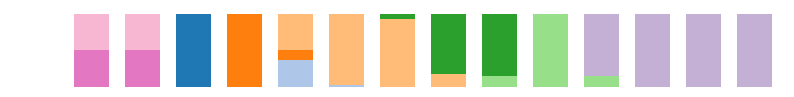

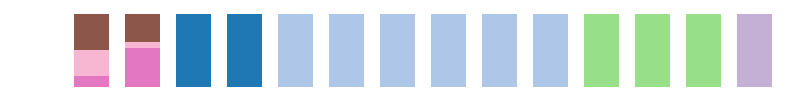

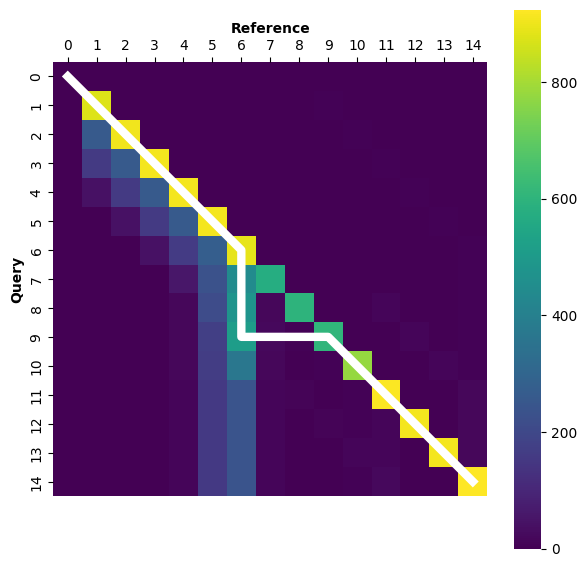

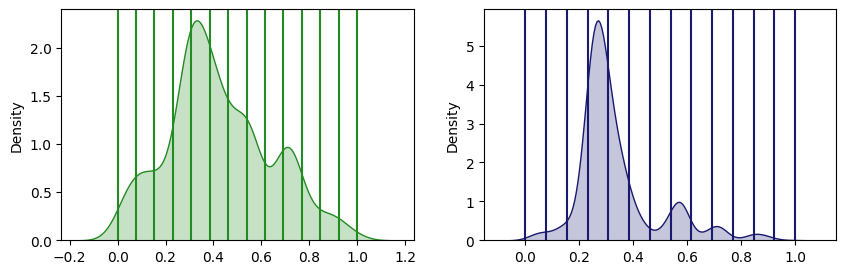

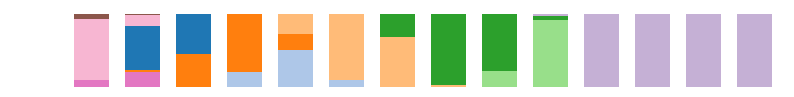

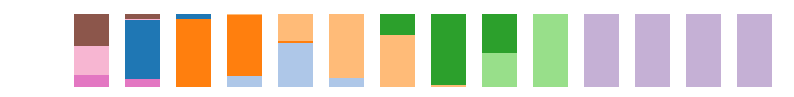

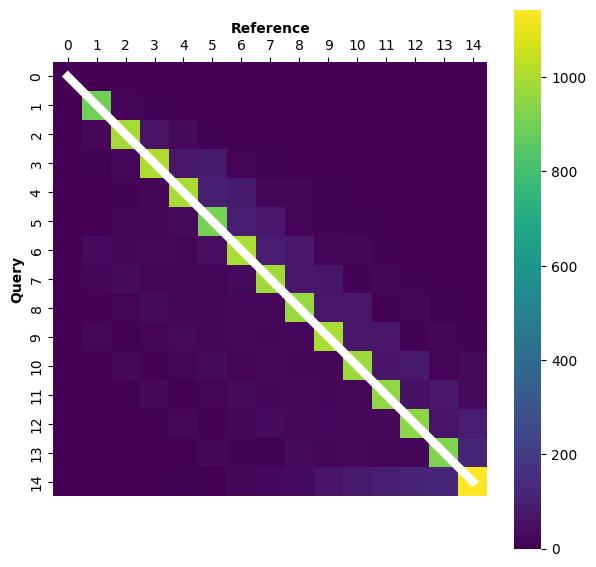

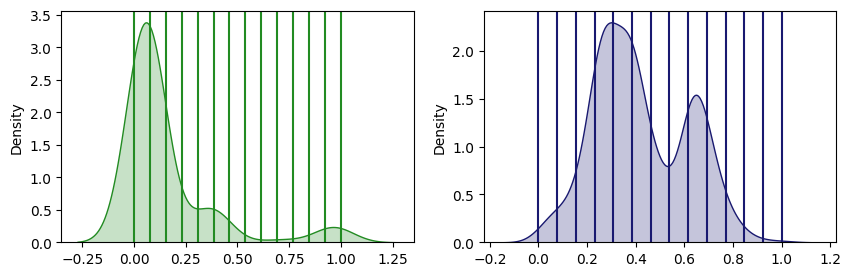

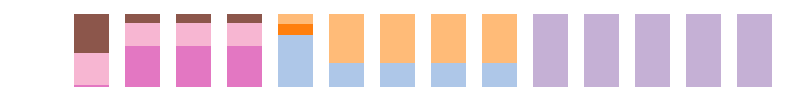

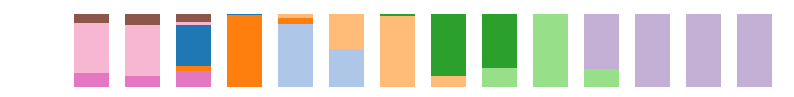

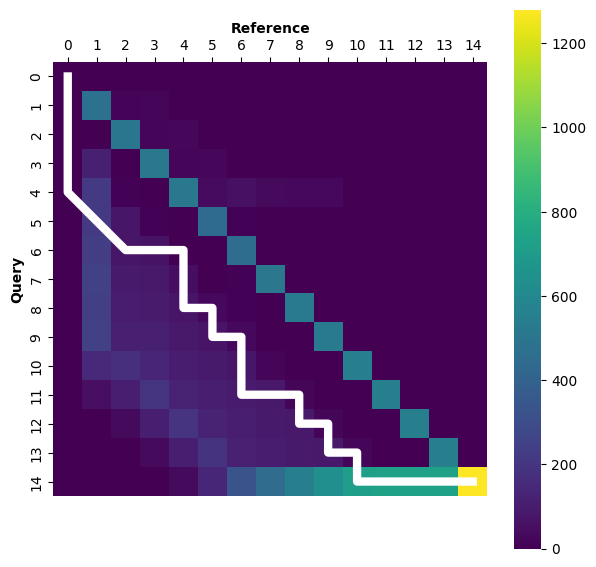

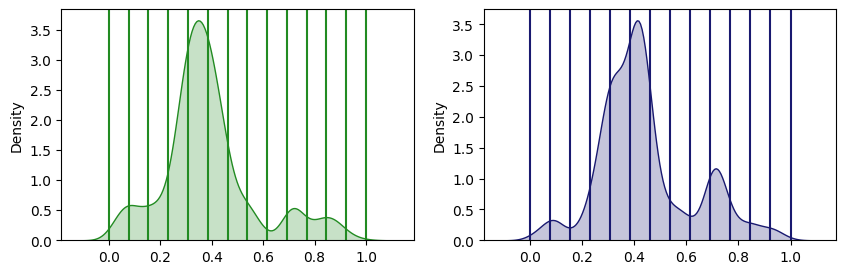

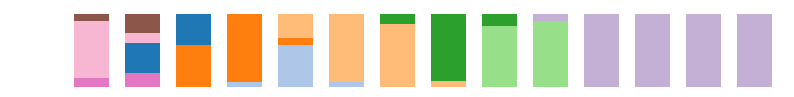

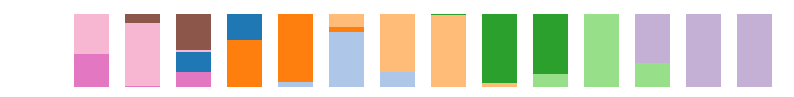

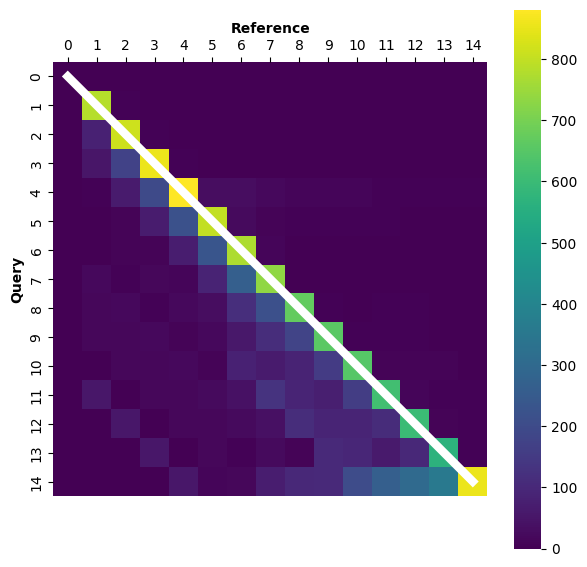

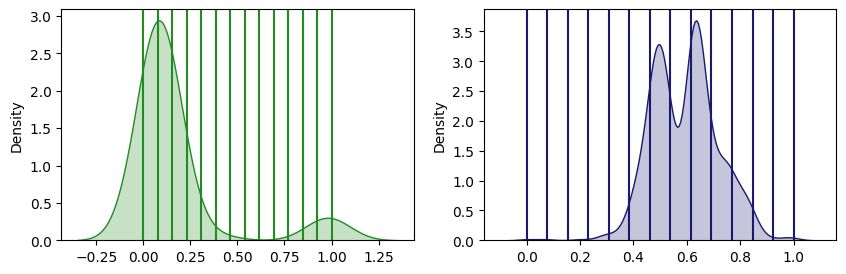

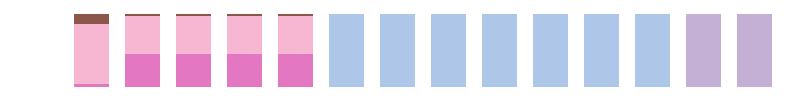

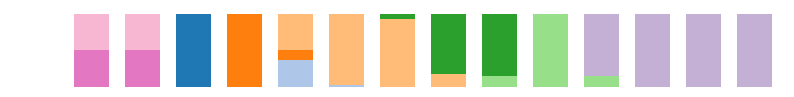

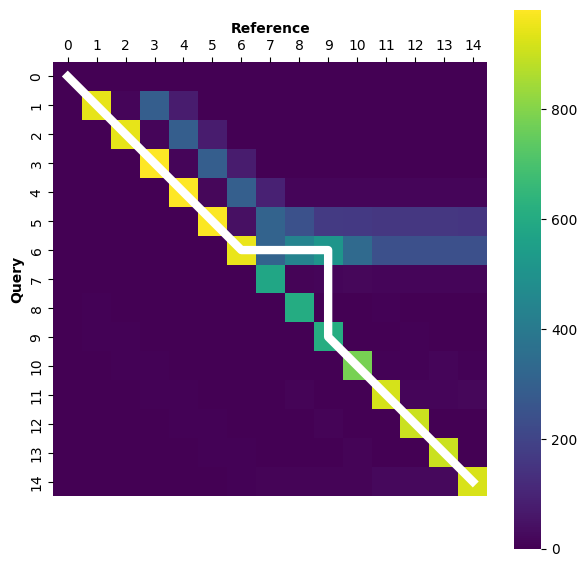

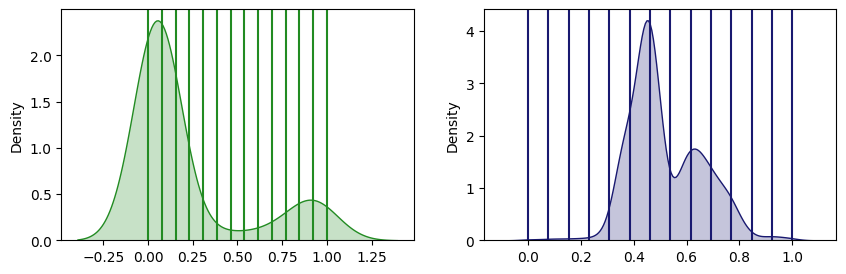

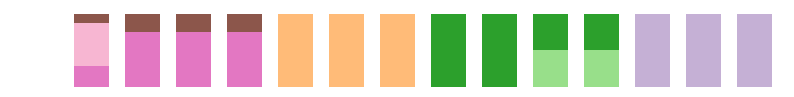

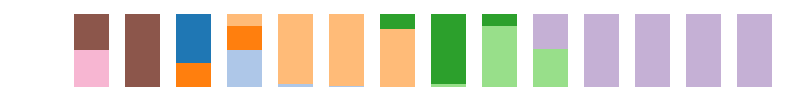

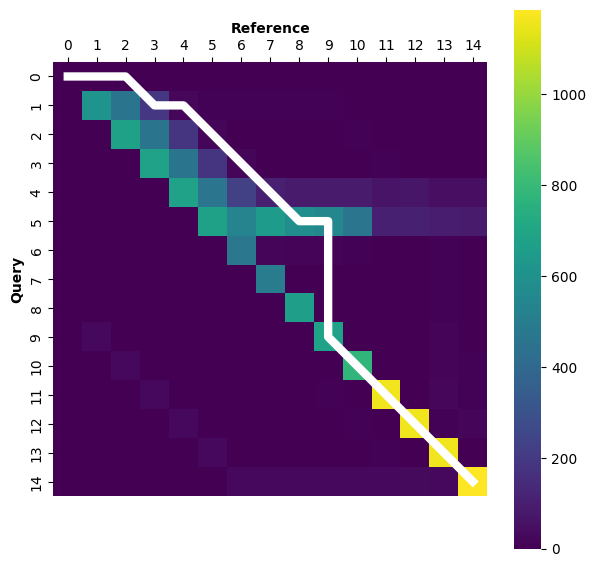

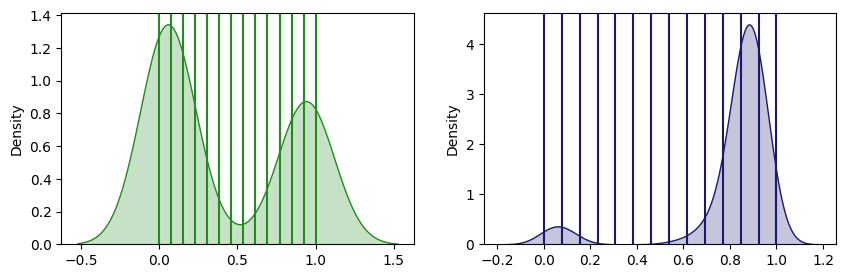

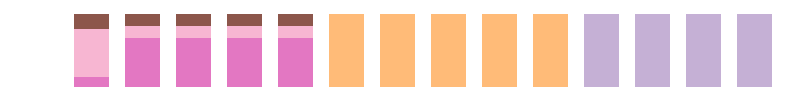

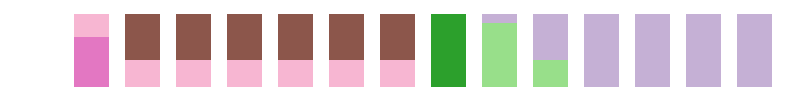

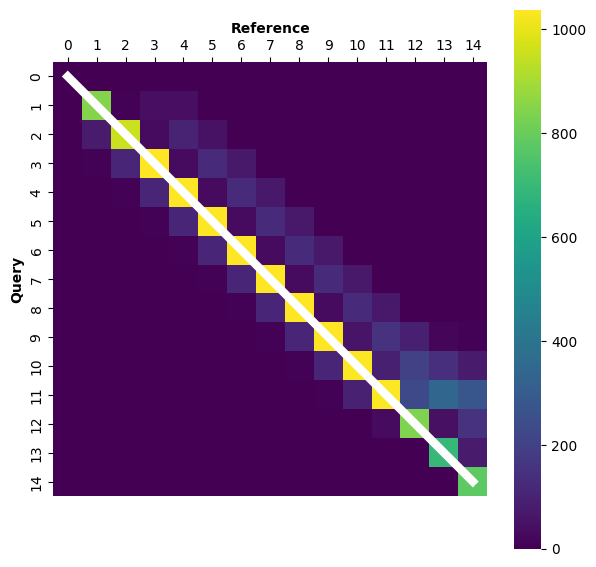

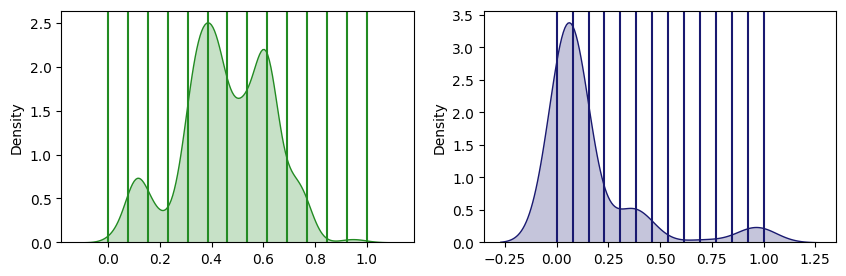

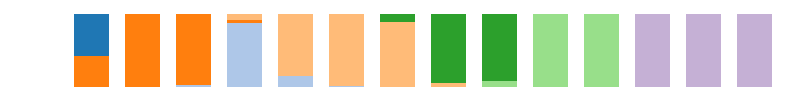

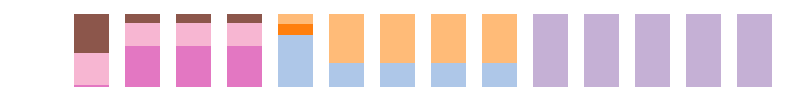

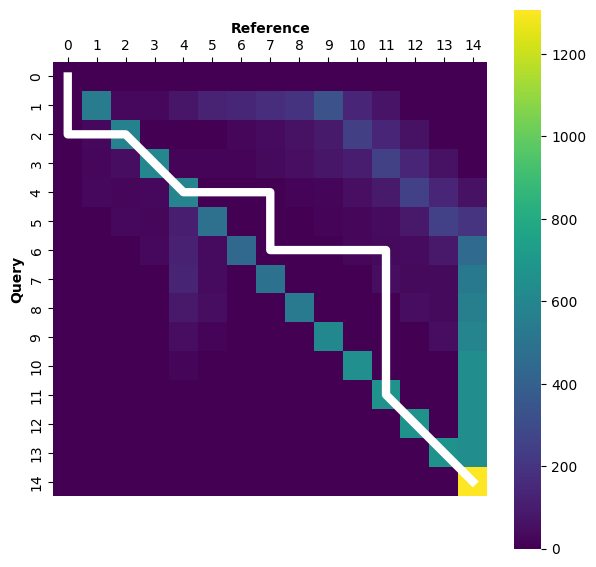

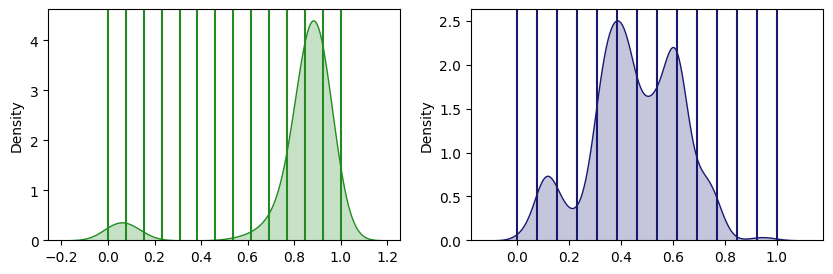

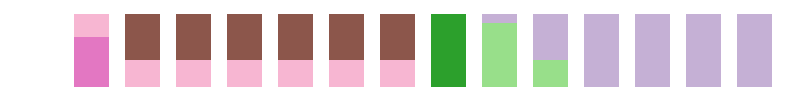

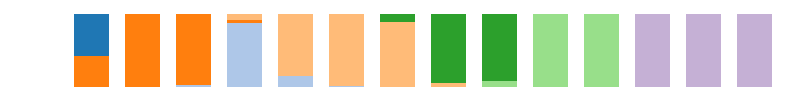

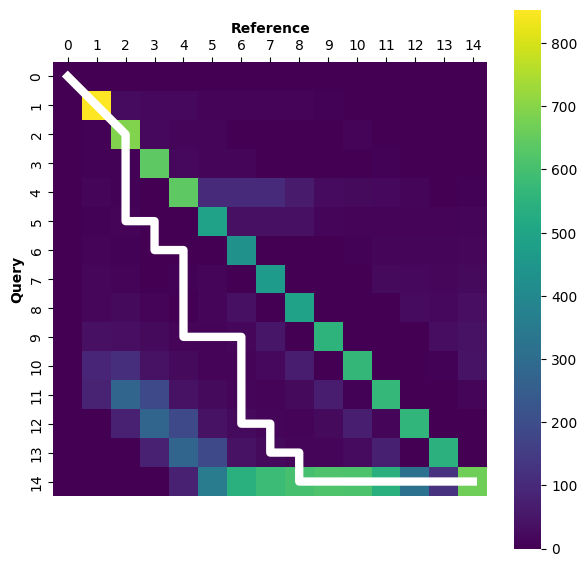

In [ ]:
# random pick of batch pairs to do alignment 
gene_list = human_TFs#np.intersect1d(human_TFs, IGS.SETS['TNF_alpha_signaling_via_NFKB'])
len(gene_list)
np.random.seed(1)
for i in range(0,10):
    selected_batches = np.random.choice(ref_donors, 2)
    print("Donor2Donor TEST ", i, ':',selected_batches)
    #if(i!=5):
    #    continue
    adata_ref_batch = adata_ref[adata_ref.obs.bbk == selected_batches[0]]
    adata_query_batch = adata_ref[adata_ref.obs.bbk == selected_batches[1]]
    print(adata_ref_batch.shape)
    print(adata_query_batch.shape)

    print( np.min(adata_ref_batch.obs.time) , np.max(adata_ref_batch.obs.time) ) 
    print( np.min(adata_query_batch.obs.time) , np.max(adata_query_batch.obs.time) ) 
    adata_ref_batch.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref_batch.obs['time']))
    adata_query_batch.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query_batch.obs['time']))
    print( np.min(adata_ref_batch.obs.time) , np.max(adata_ref_batch.obs.time) ) 
    print( np.min(adata_query_batch.obs.time) , np.max(adata_query_batch.obs.time) ) 


    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref_batch, adata_query_batch, 
                                                                  n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                                  optimal_binning=False,
                                                                 ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)

    aligner = Main.RefQueryAligner(adata_ref_batch, adata_query_batch, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    aligner.get_aggregate_alignment()
    
    temp_aligner = aligner

IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Optimal alignment cost: 72.073 nits
Alignment similarity percentage: 0.0 %


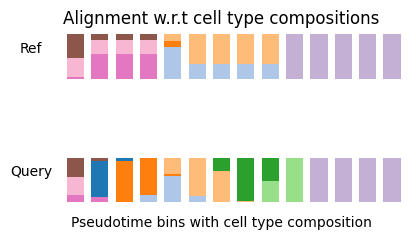

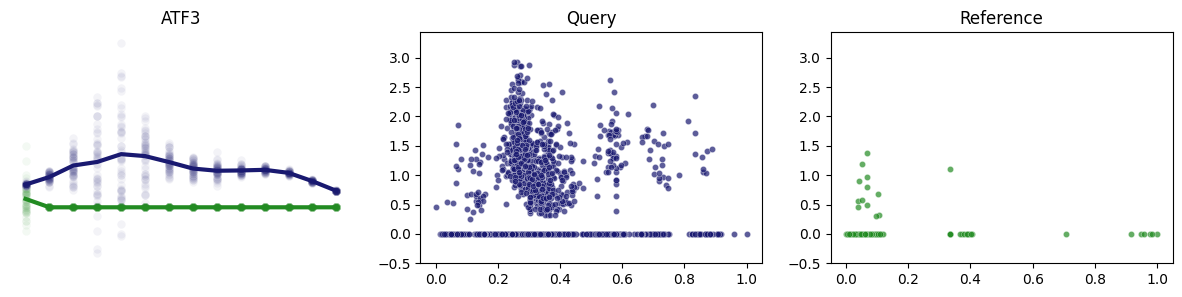

In [ ]:
VisualUtils.show_gene_alignment('ATF3', aligner, vs, joint_cmap)
plt.savefig('revision_figs/ZZZ_ATF3_donor2donor_ref_iteration1.png')

IIIMMIDIDIIIIIIIDDDDDDDDDD
Optimal alignment cost: 66.822 nits
Alignment similarity percentage: 7.69 %


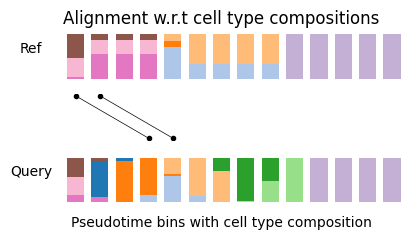

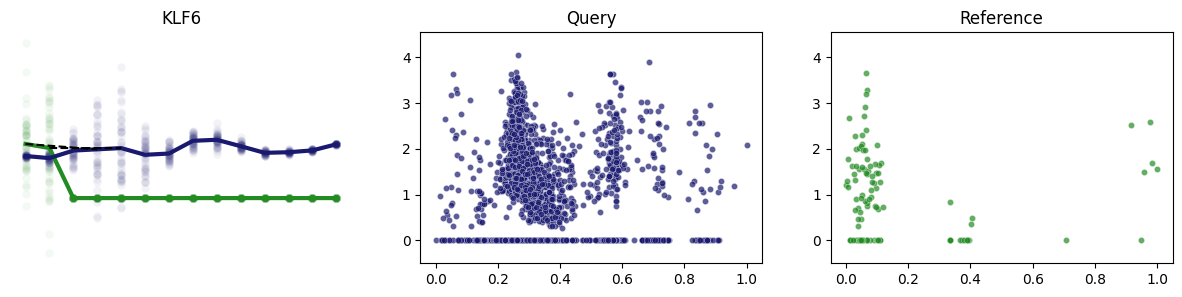

In [ ]:

VisualUtils.show_gene_alignment('KLF6', aligner, vs, joint_cmap)